In [1]:
import scipy
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
null_ratio = 0.5
cov_ratio = 0.9
mc_type = 'CHN'

## Load Data

In [3]:
mcds = xr.open_dataset(
    '/home/hanliu/project/cemba/dataset/snmC/mcds/10A_190423.mcds', chunks={'cell': 500})
mcds

<xarray.Dataset>
Dimensions:              (cell: 1238, count_type: 2, strand_type: 1, mc_type: 2, chrom100k: 27269, geneslop2k: 55487)
Coordinates:
  * cell                 (cell) object '10A_M_1003' '10A_M_1' ... '10A_M_996'
  * count_type           (count_type) object 'mc' 'cov'
  * strand_type          (strand_type) object 'both'
  * mc_type              (mc_type) object 'CHN' 'CGN'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
  * geneslop2k           (geneslop2k) object 'ENSMUSG00000102693.1' ... 'ENSM...
    geneslop2k_chrom     (geneslop2k) object dask.array<chunksize=(55487,), meta=np.ndarray>
    geneslop2k_start     (geneslop2k) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
    geneslop2k_end       (geneslop2k) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
Data variables:
    chrom100k_da         (cell, chrom100k, mc_type, strand_type, count_type) uint16 dask.array<chunksize=(500, 27269, 2, 1, 2), meta=np.ndarray>
    geneslop2k_da        (cell, geneslop2k, mc_type, strand_type, count_type) uint16 dask.array<chunksize=(500, 55487, 2, 1, 2), meta=np.ndarray>

In [4]:
cell_meta = pd.read_hdf(
    '/home/hanliu/project/cemba/study/Clustering/snmCEnsembl/summary/CEMBA_snmC.clsutering.211001.hdf')

In [5]:
use_cells = mcds.get_index('cell').intersection(cell_meta.index)
mcds = mcds.sel(cell=use_cells)

In [6]:
true_clusters = cell_meta.loc[use_cells, ['L1', 'L2', 'L3']]

## Get Null Fractions

In [7]:
cov = mcds['chrom100k_da'].sel(mc_type=mc_type,
                                    count_type='cov').squeeze()
mc = mcds['chrom100k_da'].sel(mc_type=mc_type,
                                   count_type='mc').squeeze()

cell_frac = mc.sum(axis=1) / (cov.sum(axis=1) + 0.0001)
feature_frac = mc.sum(axis=0) / (cov.sum(axis=0) + 0.0001)
true_frac = mc / (cov + 0.0001)
null_frac = np.sqrt(cell_frac @ feature_frac)

## Spike-in null fraction
- null feature only contains global average, no cell type information

In [8]:
features = true_frac.get_index('chrom100k')
null_features = np.random.choice(features, int(features.size * null_ratio), replace=False)
is_null = features.isin(null_features)

simulate_frac = xr.where(is_null[None, :], null_frac, true_frac)

### Plot

[[],
 [],
 Text(0.5, 0, 'Features'),
 Text(0, 0.5, 'Cells'),
 Text(0.5, 1.0, 'Simulation Fraction')]

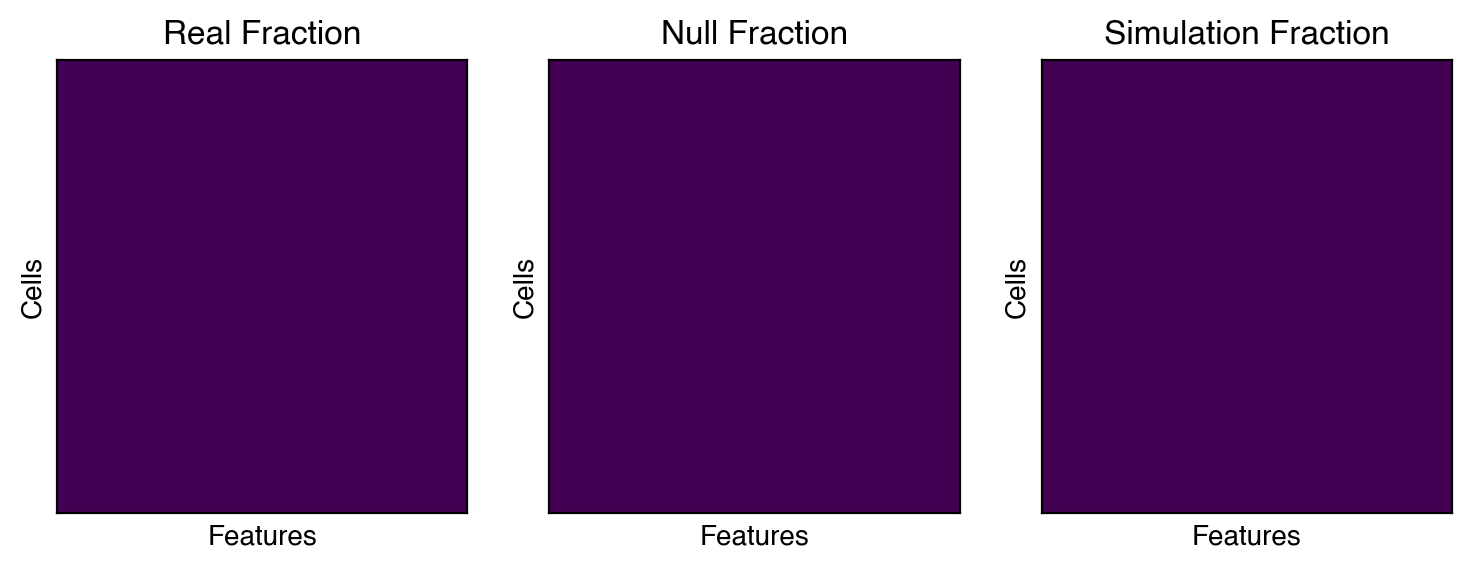

In [9]:
# cell overall mC frac, feature overall mC frac are preserved, but the value has no cell-type information
fig, axes = plt.subplots(figsize=(9, 3), dpi=200, ncols=3)

vmin = 0.5
vmax = 0.9

ax = axes[0]
ax.imshow(true_frac.values, aspect='auto', vmin=vmin, vmax=vmax)
ax.set(xticks=[], yticks=[], xlabel='Features', ylabel='Cells', title='Real Fraction')
ax = axes[1]
ax.imshow(null_frac.values, aspect='auto', vmin=vmin, vmax=vmax)
ax.set(xticks=[], yticks=[], xlabel='Features', ylabel='Cells', title='Null Fraction')
ax = axes[2]
ax.imshow(simulate_frac.values, aspect='auto', vmin=vmin, vmax=vmax)
ax.set(xticks=[], yticks=[], xlabel='Features', ylabel='Cells', title='Simulation Fraction')

## Get Simulated mC and MCDS

In [9]:
def downsample_cov(cov, cov_ratio):
    cov_f, cov_i = np.modf(cov * cov_ratio)
    # sample from bernoulli instead of doing np.round, 
    # to prevent all 0s when cov_ratio is very small
    cov = np.random.binomial(1, cov_f) + cov_i
    return cov

In [10]:
cov = downsample_cov(cov, cov_ratio)

In [11]:
# mc sampled from binom dist
sim_mc = np.random.binomial(n=cov, p=simulate_frac, size=cov.shape)
sim_mc = xr.DataArray(sim_mc, 
                      dims=['cell', 'chrom100k'], 
                      coords=[simulate_frac.get_index('cell'), 
                              simulate_frac.get_index('chrom100k')])
sim_mc.coords['count_type'] = 'mc'

In [12]:
sim_mcds = xr.Dataset({'chrom100k_da': xr.concat([sim_mc, cov], dim='count_type')})

In [13]:
sim_mcds.load()

<xarray.Dataset>
Dimensions:              (chrom100k: 27269, cell: 1143, count_type: 2)
Coordinates:
    mc_type              <U3 'CHN'
    chrom100k_chrom      (chrom100k) object 'chr1' 'chr1' ... 'chrY' 'chrM'
    chrom100k_bin_start  (chrom100k) int64 0 100000 200000 ... 91700000 0
    chrom100k_bin_end    (chrom100k) int64 100000 200000 ... 91744698 16299
    strand_type          <U4 'both'
  * cell                 (cell) object '10A_M_1003' '10A_M_1' ... '10A_M_996'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
  * count_type           (count_type) <U3 'mc' 'cov'
Data variables:
    chrom100k_da         (count_type, cell, chrom100k) float64 0.0 0.0 ... 274.0

In [14]:
sim_mcds.to_zarr('simulated.mcds', mode='w')

In [15]:
true_clusters.to_csv('true_labels.csv')

In [16]:
simulate_frac.values

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0064935 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00591133],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01886791],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00791139],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00657895]])